# Called Third Strike
### _Building a Strike Probability Model_
<div>
<img src="resources/baseball_umpire_home_plate_1.jpg" width="600"/>
</div>

---
## Part 6. Improved non-neural network model

This project's goal is to build probability models for as to whether a pitch will be called a strike or not. The intended models are to be:
1. A neural network (NN) based approach.
2. A non-NN based approach.

---

__**This Notebook's**__ objective is to iterate on the work done with the [first attempts](./04_first_quick_non_nn_model.ipynb) at a "classical" ML classication model. As with the ['improved' neural network model](./05_improved_neural_network.ipynb), we will be adding in these other features:
- Included Handedness of both pitcher and batter; I hypothesize that this will have some signal with regards to the 'strike-ness' of the horizontal movement of the pitch. As for verticality, I think that the stringer data helps with that since it provides fairly concrete guardrails as to the strike-ness (assuming the umpire sees the same thing haha).
- Include pitch break and angle. I hypothesize this acts like a proxy to the pitcher, without having to rely on the pitcher_IDs. Rough analogy but I think of it kind of like latent factors in ALS matrix factorization (which I need to brush up on heh).

---
---

### Table of Contents<a id='toc_6'></a>

<a href='#data_prep'>1. Data Preprocessing</a>

~<a href='#build_model'>2. Build Model</a>~ Straight to Random Search!

<a href='#random_search'>3. Random Hyperparameter Search</a>

<a href='#summary'>4. Summary</a>

<a href='#6_wrapup'>5. Wrap Up `XGBoost`</a>

...

<a href='#6_the_end'>Go to the End</a>


<span style="font-size:0.75em;">Note that some hyperlinks in this notebook may only work in a local context.</span>

---

---  

<span style="font-size:0.5em;">Tag 1</span>

### Data Preprocessing<a id='data_prep'></a>

<span style="font-size:0.5em;"><a href='#toc_6'>Back to TOC</a></span>


#### Libraries


In [1]:
# Data wrangling and operations
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import pytz
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# try:
#     import plotly_express as pex
# except ImportError:
#     !pip install plotly_express
# except ModuleNotFoundError:
#     !pip install plotly_express

# Estimators
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import BaseEstimator

# Processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Assessment
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, auc
from sklearn.metrics import roc_curve, RocCurveDisplay

# Custom
from project_helpers import DummyEstimator

2022-05-12 12:57:49.706741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-12 12:57:49.706769: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


---

#### Data Import 

Retrieve the latest version of our train/test files that we built during [initial exploration](./02_data_exploration.ipynb).

In [2]:
df_train = pd.read_pickle('../data/train_enriched.pkl')
df_test = pd.read_pickle('../data/test_enriched.pkl')

Let's refamiliarize ourselves with the features.

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350959 entries, 0 to 354038
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   pitch_id              350959 non-null  object        
 1   inning                350959 non-null  int64         
 2   side                  350959 non-null  object        
 3   run_diff              350959 non-null  int64         
 4   at_bat_index          350959 non-null  int64         
 5   pitch_of_ab           350959 non-null  int64         
 6   batter                350959 non-null  int64         
 7   pitcher               350959 non-null  int64         
 8   catcher               350959 non-null  int64         
 9   umpire                350959 non-null  int64         
 10  bside                 350959 non-null  object        
 11  pside                 350959 non-null  object        
 12  stringer_zone_bottom  350959 non-null  float64       
 13 

---

#### Feature Selection and Prep, revisited

Select features:

For our initial super simple model, we had picked just four features: 
- `px` which is the horizontal location of the pitch at the plate
- `pz` which is the vertical location
- `stringer_zone_bottom` which is an estimate of current batter's strike zone bottom
- `stringer_zone_top` which is an estimate of current batter's strike zone top

In [4]:
# Features selected
feat_select = ['px', 'pz', 'stringer_zone_bottom', 'stringer_zone_top']

But as mentioned in the intro, I want to try adding `bside` and `pside`, as well as vertical/horizontal breaks and angles (`break_x`, `break_z`, `angle_x`, `angle_z`), and `pitch_speed`. 

##### Adding `break_x`, `break_z`, `angle_x`, `angle_z`, `pitch_speed`

These are numeric so I will add on to `feat_select`

In [5]:
feat_select = feat_select + ['break_x', 'break_z', 'angle_x', 'angle_z', 'pitch_speed']
feat_select = list(set(feat_select)) #Just to ensure no dupes if this cell gets executed again
display(feat_select)

['angle_z',
 'pitch_speed',
 'px',
 'angle_x',
 'break_z',
 'stringer_zone_top',
 'break_x',
 'stringer_zone_bottom',
 'pz']

##### Adding `b_side`, `p_side`

These are strings so I will one-hot encode them.

In [6]:
feat_cat_select = ['bside', 'pside']

In [7]:
df_train_cat_ohe = pd.get_dummies(df_train[feat_cat_select])

In [8]:
df_train_cat_ohe.head(3)

,bside_L,bside_R,pside_L,pside_R
0,0,1,1,0
1,1,0,0,1
2,1,0,1,0


In [9]:
df_train_cat_ohe.shape

(350959, 4)

Prep features:

Gather up all the selected features.

In [10]:
# Get just the selected features
df_X = pd.concat([df_train[feat_select], df_train_cat_ohe], axis=1)
# df_X = df_train_cat_ohe.copy()
display(df_X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350959 entries, 0 to 354038
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   angle_z               350959 non-null  float64
 1   pitch_speed           350959 non-null  float64
 2   px                    350959 non-null  float64
 3   angle_x               350959 non-null  float64
 4   break_z               350959 non-null  float64
 5   stringer_zone_top     350959 non-null  float64
 6   break_x               350959 non-null  float64
 7   stringer_zone_bottom  350959 non-null  float64
 8   pz                    350959 non-null  float64
 9   bside_L               350959 non-null  uint8  
 10  bside_R               350959 non-null  uint8  
 11  pside_L               350959 non-null  uint8  
 12  pside_R               350959 non-null  uint8  
dtypes: float64(9), uint8(4)
memory usage: 28.1 MB


None

In [11]:
df_X.head()

,angle_z,pitch_speed,px,angle_x,break_z,stringer_zone_top,break_x,stringer_zone_bottom,pz,bside_L,bside_R,pside_L,pside_R
0,5.59379,97.4298,-1.298100,3.02727,-9.54142,3.41,1.915350,1.56,2.302170,0,1,1,0
1,6.86676,91.7712,1.412220,-1.56782,-21.94270,3.47,-12.137300,1.59,1.574430,1,0,0,1
2,7.17281,87.8130,-0.181190,2.04966,-25.51070,3.58,-0.992261,1.68,2.112480,1,0,1,0
3,8.50392,86.5546,-0.885538,2.96845,-27.25090,3.55,-2.839300,1.63,0.598692,0,1,1,0
5,9.33291,72.0904,-1.459540,-1.64630,-59.41330,3.30,8.906150,1.50,3.399510,1,0,0,1


In [12]:
col_primary_order = list(df_X.columns)
col_primary_order.sort()
col_primary_order

['angle_x',
 'angle_z',
 'break_x',
 'break_z',
 'bside_L',
 'bside_R',
 'pitch_speed',
 'pside_L',
 'pside_R',
 'px',
 'pz',
 'stringer_zone_bottom',
 'stringer_zone_top']

In [13]:
df_X = df_X[col_primary_order]

In [14]:
df_X.head()

,angle_x,angle_z,break_x,break_z,bside_L,bside_R,pitch_speed,pside_L,pside_R,px,pz,stringer_zone_bottom,stringer_zone_top
0,3.02727,5.59379,1.915350,-9.54142,0,1,97.4298,1,0,-1.298100,2.302170,1.56,3.41
1,-1.56782,6.86676,-12.137300,-21.94270,1,0,91.7712,0,1,1.412220,1.574430,1.59,3.47
2,2.04966,7.17281,-0.992261,-25.51070,1,0,87.8130,1,0,-0.181190,2.112480,1.68,3.58
3,2.96845,8.50392,-2.839300,-27.25090,0,1,86.5546,1,0,-0.885538,0.598692,1.63,3.55
5,-1.64630,9.33291,8.906150,-59.41330,1,0,72.0904,0,1,-1.459540,3.399510,1.50,3.30


While we are at it, let's prep our targets:

In [15]:
df_y = df_train['strike_bool']
display(pd.DataFrame(df_y).info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350959 entries, 0 to 354038
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   strike_bool  350959 non-null  int64
dtypes: int64(1)
memory usage: 5.4 MB


None

##### Prep Holdout

Let's also perform the same with our holdout data so we can easily make predictions with our ultimately selected model.

One hot encoding selected cats:

In [16]:
df_hold_cat_ohe = pd.get_dummies(df_test[feat_cat_select])

In [17]:
df_hold_cat_ohe.head()

,bside_L,bside_R,pside_L,pside_R
0,1,0,0,1
1,0,1,1,0
2,0,1,0,1
3,0,1,1,0
4,0,1,0,1


In [18]:
# Get just the selected features
df_holdout = pd.concat([df_test[feat_select], df_hold_cat_ohe], axis=1)
# df_X = df_train_cat_ohe.copy()
display(df_holdout.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18633 entries, 0 to 18632
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   angle_z               18633 non-null  float64
 1   pitch_speed           18633 non-null  float64
 2   px                    18633 non-null  float64
 3   angle_x               18633 non-null  float64
 4   break_z               18633 non-null  float64
 5   stringer_zone_top     18633 non-null  float64
 6   break_x               18633 non-null  float64
 7   stringer_zone_bottom  18633 non-null  float64
 8   pz                    18633 non-null  float64
 9   bside_L               18633 non-null  uint8  
 10  bside_R               18633 non-null  uint8  
 11  pside_L               18633 non-null  uint8  
 12  pside_R               18633 non-null  uint8  
dtypes: float64(9), uint8(4)
memory usage: 1.4 MB


None

In [19]:
df_X.head(5)

,angle_x,angle_z,break_x,break_z,bside_L,bside_R,pitch_speed,pside_L,pside_R,px,pz,stringer_zone_bottom,stringer_zone_top
0,3.02727,5.59379,1.915350,-9.54142,0,1,97.4298,1,0,-1.298100,2.302170,1.56,3.41
1,-1.56782,6.86676,-12.137300,-21.94270,1,0,91.7712,0,1,1.412220,1.574430,1.59,3.47
2,2.04966,7.17281,-0.992261,-25.51070,1,0,87.8130,1,0,-0.181190,2.112480,1.68,3.58
3,2.96845,8.50392,-2.839300,-27.25090,0,1,86.5546,1,0,-0.885538,0.598692,1.63,3.55
5,-1.64630,9.33291,8.906150,-59.41330,1,0,72.0904,0,1,-1.459540,3.399510,1.50,3.30


In [20]:
df_holdout.head(5)

,angle_z,pitch_speed,px,angle_x,break_z,stringer_zone_top,break_x,stringer_zone_bottom,pz,bside_L,bside_R,pside_L,pside_R
0,8.02184,88.1309,-0.689798,-0.261130,-31.5262,3.37,-16.171500,1.53,0.880993,1,0,0,1
1,2.30556,93.8505,0.670993,-1.285440,-15.4120,3.37,12.789200,1.53,4.807010,0,1,1,0
2,7.95176,87.1178,0.550363,-3.152060,-30.0377,3.41,6.324360,1.56,2.374940,0,1,0,1
3,6.08815,92.9043,0.884750,0.699183,-20.9565,3.47,12.111500,1.59,2.420760,0,1,1,0
4,6.37698,86.5579,-0.343300,-2.418760,-25.6905,3.41,0.996405,1.47,2.650810,0,1,0,1


In [21]:
df_holdout = df_holdout[col_primary_order]

In [22]:
df_X.head(5)

,angle_x,angle_z,break_x,break_z,bside_L,bside_R,pitch_speed,pside_L,pside_R,px,pz,stringer_zone_bottom,stringer_zone_top
0,3.02727,5.59379,1.915350,-9.54142,0,1,97.4298,1,0,-1.298100,2.302170,1.56,3.41
1,-1.56782,6.86676,-12.137300,-21.94270,1,0,91.7712,0,1,1.412220,1.574430,1.59,3.47
2,2.04966,7.17281,-0.992261,-25.51070,1,0,87.8130,1,0,-0.181190,2.112480,1.68,3.58
3,2.96845,8.50392,-2.839300,-27.25090,0,1,86.5546,1,0,-0.885538,0.598692,1.63,3.55
5,-1.64630,9.33291,8.906150,-59.41330,1,0,72.0904,0,1,-1.459540,3.399510,1.50,3.30


In [23]:
df_holdout.head(5)

,angle_x,angle_z,break_x,break_z,bside_L,bside_R,pitch_speed,pside_L,pside_R,px,pz,stringer_zone_bottom,stringer_zone_top
0,-0.261130,8.02184,-16.171500,-31.5262,1,0,88.1309,0,1,-0.689798,0.880993,1.53,3.37
1,-1.285440,2.30556,12.789200,-15.4120,0,1,93.8505,1,0,0.670993,4.807010,1.53,3.37
2,-3.152060,7.95176,6.324360,-30.0377,0,1,87.1178,0,1,0.550363,2.374940,1.56,3.41
3,0.699183,6.08815,12.111500,-20.9565,0,1,92.9043,1,0,0.884750,2.420760,1.59,3.47
4,-2.418760,6.37698,0.996405,-25.6905,0,1,86.5579,0,1,-0.343300,2.650810,1.47,3.41


---

#### Feature Engineering

Select features:

We should need numerically represent our data (e.g. one-hot-encode any categorical features), as well as scale/normalize the data. 

All the selected features for this round are numerical, so we don't have to worry about encoding any categories. For scaling I'm choosing to *standardize*.

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X)

Let's also scale our holdout data to make sure it is ready for predictions.

In [25]:
X_scaled.shape

(350959, 13)

`pickle` out the `scaler` for future use

In [26]:
%%script echo skipping
str_ts = datetime.now(timezone.utc).astimezone(pytz.timezone('US/Pacific')).strftime("%Y%m%d_%H%M")

xgb_scaler_path = './models/xgb_scaler_' + str_ts + '.pickle'
display(xgb_scaler_path)

with open(xgb_scaler_path, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(scaler, f, pickle.HIGHEST_PROTOCOL)

skipping


In [27]:
holdout_scaled = scaler.transform(df_holdout)

In [28]:
holdout_scaled.shape

(18633, 13)

---

#### Train / Test


Create train/test splits.

Breakout parameters for easy access.

In [29]:
# Parameters
test_size = 0.20
random_state = 24

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df_y, test_size=test_size
                                                    ,stratify=df_y, random_state = random_state)

---  

<span style="font-size:0.5em;">Tag 2</span>

### Build Model / Hyperparameter Search<a id='random_search'></a>

<span style="font-size:0.5em;"><a href='#toc_6'>Back to TOC</a></span>

---  

For expediency we are going to use a pipeline and random hyperparameter search to scour through different classifiers and hyperparameter sets to come up with a good candidate.

We'll use a `DummyEstimator` class to act as a placeholder to which we can pass the different classifiers. See [here](./project_helpers.py).

Create the pipeline of dictionaries of classifiers and their respective grids of potential hyperparameters.

I noticed in my first run that the grid parameters were erroneous for GBM. This time around let's skip GBM since we are already going to search XGBoost anyway. We almost make this case for also removing Random Forests, but I want those more 'classic' models to have something to compare against (and to see if they can perform well!).

Also, the asset I'm using has a timeout 'feature' so I can't really run a large grid without tending to the notebook regularly. So I will break up the search into three pieces that should run for more manageable lengths of time.

In [56]:
# Create a pipeline
pipe_lr = Pipeline([('clf', DummyEstimator())]) # Placeholder Estimator
pipe_rf = Pipeline([('clf', DummyEstimator())]) # Placeholder Estimator
pipe_xgb = Pipeline([('clf', DummyEstimator())]) # Placeholder Estimator

# Candidate learning algorithms and their hyperparameters
# For selected hyperparameters aimed to select a reasonable range for each.

# Going to break up the search space into 3
search_space_lr = [{'clf': [LogisticRegression()], # Actual Estimator
                     'clf__C': [100, 10, 1.0, 0.1, 0.01]
                    }
                   ]

search_space_rf = [{'clf': [RandomForestClassifier()],  # Actual Estimator
                     'clf__n_estimators': [50, 100, 200],
                     'clf__criterion': ['gini', 'entropy'],                 
                     'clf__max_depth': np.arange(3,11,1),
                     'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                     'clf__max_features': ["auto", "sqrt", "log2"],
                     'clf__max_samples': [0.25, 0.5, 0.75, 1]
                    }
                   ]

search_space_xgb = [{'clf': [XGBClassifier()],  # Actual Estimator
                     'clf__n_estimators': [50, 100, 200],
                     'clf__criterion': ['gini', 'entropy'],                 
                     'clf__max_depth': np.arange(3,11,1),
                     'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                     'clf__max_features': ["auto", "sqrt", "log2"],
                     'clf__max_samples': [0.25, 0.5, 0.75, 1]
                    }
                   ]

# Create grid search 
# gs = GridSearchCV(pipe, search_space, random_state=random_state)
rs_lr = RandomizedSearchCV(pipe_lr, search_space_lr, random_state=random_state
                        ,n_iter=5 # To limit search time 
                        ,cv=3      # I like 5 as rule of thumb, but again to limit search time
                        ,verbose=True, refit=True, scoring='accuracy')

rs_rf = RandomizedSearchCV(pipe_rf, search_space_rf, random_state=random_state
                        ,n_iter=5 # To limit search time 
                        ,cv=3      # I like 5 as rule of thumb, but again to limit search time
                        ,verbose=True, refit=True, scoring='accuracy')

rs_xgb = RandomizedSearchCV(pipe_xgb, search_space_xgb, random_state=random_state
                        ,n_iter=5 # To limit search time 
                        ,cv=3      # I like 5 as rule of thumb, but again to limit search time
                        ,verbose=True, refit=True, scoring='accuracy')

Fit the LR random search cv object.

Let's pickle the random search results.

**Logistic Regression grid**

In [57]:
rs_lr_results = rs_lr.fit(X_train, y_train)
print(datetime.now())

#Timestamp
str_ts = datetime.now(timezone.utc).astimezone(pytz.timezone('US/Pacific')).strftime("%Y%m%d_%H%M")

res_lr_nm = 'classic_2nd_pass_rs_lr_' + str_ts
res_lr_file_path = './models/rs_results/' + res_lr_nm + '.pickle'

best_lr_nm = 'classic_2nd_pass_best_model_lr_' + str_ts
best_lr_file_path = './models/rs_results/' + best_lr_nm + '.pickle'

display(best_lr_nm)
display(best_lr_file_path)

with open(res_lr_file_path, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(rs_lr_results, f, pickle.HIGHEST_PROTOCOL)

with open(best_lr_file_path, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(rs_lr_results.best_estimator_, f, pickle.HIGHEST_PROTOCOL)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
2022-05-12 14:09:17.586124


'classic_2nd_pass_best_model_lr_20220512_0709'

'./models/rs_results/classic_2nd_pass_best_model_lr_20220512_0709.pickle'

**Random Forest grid**

In [40]:
rs_rf_results = rs_rf.fit(X_train, y_train)
print(datetime.now())

#Timestamp
str_ts = datetime.now(timezone.utc).astimezone(pytz.timezone('US/Pacific')).strftime("%Y%m%d_%H%M")

res_rf_nm = 'classic_2nd_pass_rs_rf_' + str_ts
res_rf_file_path = './models/rs_results/' + res_rf_nm + '.pickle'

best_rf_nm = 'classic_2nd_pass_best_model_rf_' + str_ts
best_rf_file_path = './models/rs_results/' + best_rf_nm + '.pickle'

display(best_rf_nm)
display(best_rf_file_path)

with open(res_rf_file_path, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(rs_rf_results, f, pickle.HIGHEST_PROTOCOL)

with open(best_rf_file_path, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(rs_rf_results.best_estimator_, f, pickle.HIGHEST_PROTOCOL)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
2022-05-12 05:13:24.317918


'classic_2nd_pass_best_model_rf_20220511_2213'

'./models/rs_results/classic_2nd_pass_best_model_rf_20220511_2213.pickle'

In [41]:
rs_xgb_results = rs_xgb.fit(X_train, y_train)
print(datetime.now())

#Timestamp
str_ts = datetime.now(timezone.utc).astimezone(pytz.timezone('US/Pacific')).strftime("%Y%m%d_%H%M")

res_xgb_nm = 'classic_2nd_pass_rs_xgb_' + str_ts
res_xgb_file_path = './models/rs_results/' + res_xgb_nm + '.pickle'

best_xgb_nm = 'classic_2nd_pass_best_model_xgb_' + str_ts
best_xgb_file_path = './models/rs_results/' + best_xgb_nm + '.pickle'

display(best_xgb_nm)
display(best_xgb_file_path)

with open(res_xgb_file_path, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(rs_xgb_results, f, pickle.HIGHEST_PROTOCOL)

with open(best_xgb_file_path, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(rs_xgb_results.best_estimator_, f, pickle.HIGHEST_PROTOCOL)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[05:13:24] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, max_features, max_samples, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:13:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:17:19] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, max_features, max_samples, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  

'classic_2nd_pass_best_model_xgb_20220511_2250'

'./models/rs_results/classic_2nd_pass_best_model_xgb_20220511_2250.pickle'

##### "Re-constitute" results, if necessary

Logistic Regression

In [59]:
# %%script echo skipping
# Test loading pickle
load_path_rs_lr = './models/rs_results/classic_2nd_pass_rs_lr_20220512_0709.pickle'
load_path_best_lr = './models/rs_results/classic_2nd_pass_best_model_lr_20220512_0709.pickle'

with open(load_path_rs_lr, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    rs_lr_results = pickle.load(f)    

with open(load_path_best_lr, 'rb') as f:
    best_lr = pickle.load(f)   

Random Forest

In [37]:
# %%script echo skipping
# Test loading pickle
load_path_rs_rf = './models/rs_results/classic_2nd_pass_rs_rf_20220511_2213.pickle'
load_path_best_rf = './models/rs_results/classic_2nd_pass_best_model_rf_20220511_2213.pickle'

with open(load_path_rs_rf, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    rs_rf_results = pickle.load(f)    

with open(load_path_best_rf, 'rb') as f:
    best_rf = pickle.load(f)   

XGBoost

In [38]:
# %%script echo skipping
# Test loading pickle
load_path_rs_xgb = './models/rs_results/classic_2nd_pass_rs_xgb_20220511_2250.pickle'
load_path_best_xgb = './models/rs_results/classic_2nd_pass_best_model_xgb_20220511_2250.pickle'

with open(load_path_rs_xgb, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    rs_xgb_results = pickle.load(f)    

with open(load_path_best_xgb, 'rb') as f:
    best_xgb = pickle.load(f)   

Create combined `DataFrame` of cv results

In [60]:
df_rs_lr = pd.DataFrame(rs_lr_results.cv_results_)
display(f'df LR shape: {df_rs_lr.shape}')
df_rs_rf = pd.DataFrame(rs_rf_results.cv_results_)
display(f'df RF shape: {df_rs_rf.shape}')
df_rs_xgb = pd.DataFrame(rs_xgb_results.cv_results_)
display(f'df XGB shape: {df_rs_xgb.shape}')

# Combine dataframes
df_rs_cv = pd.concat([df_rs_lr, df_rs_rf, df_rs_xgb], axis=0)

# Create clf_type column
df_rs_cv['clf_type'] = df_rs['param_clf'].apply(lambda x: type(x).__name__)
df_rs_cv['clf_type'].value_counts()

'df LR shape: (5, 13)'

'df RF shape: (5, 18)'

'df XGB shape: (5, 18)'

LogisticRegression        5
RandomForestClassifier    5
XGBClassifier             5
Name: clf_type, dtype: int64

In [61]:
df_rs_lr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.538075,0.390619,0.101630,0.001808,100,LogisticRegression(C=100),"{'clf__C': 100, 'clf': LogisticRegression(C=100)}",0.686309,0.687859,0.686341,0.686836,0.000723,1
1,2.463021,0.415962,0.102480,0.003647,10,LogisticRegression(C=100),"{'clf__C': 10, 'clf': LogisticRegression(C=100)}",0.686309,0.687859,0.686341,0.686836,0.000723,1
2,2.529414,0.332971,0.068705,0.041070,1.0,LogisticRegression(C=100),"{'clf__C': 1.0, 'clf': LogisticRegression(C=100)}",0.686309,0.687859,0.686341,0.686836,0.000723,1
3,2.767988,0.167736,0.131784,0.043286,0.1,LogisticRegression(C=100),"{'clf__C': 0.1, 'clf': LogisticRegression(C=100)}",0.686309,0.687859,0.686341,0.686836,0.000723,1
4,2.563046,0.311111,0.105218,0.005071,0.01,LogisticRegression(C=100),"{'clf__C': 0.01, 'clf': LogisticRegression(C=1...",0.686309,0.687859,0.686341,0.686836,0.000723,1


In [64]:
df_rs_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_clf__C', 'param_clf', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'param_clf__n_estimators',
       'param_clf__min_samples_split', 'param_clf__max_samples',
       'param_clf__max_features', 'param_clf__max_depth',
       'param_clf__criterion', 'clf_type'],
      dtype='object')

**Let's looks at high level performance:**

In [62]:
df_rs_cv[['clf_type', 'mean_test_score']].sort_values(by=['mean_test_score'], ascending=[False])

,clf_type,mean_test_score
3,XGBClassifier,0.931007
2,XGBClassifier,0.930765
1,XGBClassifier,0.930729
4,XGBClassifier,0.930601
0,XGBClassifier,0.929226
4,RandomForestClassifier,0.839472
0,RandomForestClassifier,0.686865
1,RandomForestClassifier,0.686865
2,RandomForestClassifier,0.686865
3,RandomForestClassifier,0.686865


In [66]:
df_rs_rf.T

,0,1,2,3,4
mean_fit_time,19.66644,3.222305,1.418822,2.779384,3.878276
std_fit_time,0.137401,0.027907,0.005656,0.008995,0.142227
mean_score_time,0.889051,0.637222,0.317149,0.624581,0.250263
std_score_time,0.001983,0.015343,0.000193,0.001822,0.003861
param_clf__n_estimators,200,200,100,200,50
param_clf__min_samples_split,0.26,0.46,0.26,0.38,0.14
param_clf__max_samples,0.75,0.5,1,1,0.5
param_clf__max_features,sqrt,sqrt,log2,sqrt,auto
param_clf__max_depth,7,5,3,4,9
param_clf__criterion,entropy,gini,gini,entropy,gini


**Observations:**  
- `XGBoost` performs consisently above the others, which is to be expected. In real world it tends to do that as well :)
- Random Forest lag behind with one combination breaking the .800 mark, which might have to do with it's larger `max_depth`
- `LogisticRegression` was a non-starter. They all performed identically regardless. While I am curious to dig into that, it's not practical for the purposes of this exercise since we `XGBoost` performed far much better.


The most promising model came from the `XGBoost` run, so let's review the `best_model_`'s results.

In [68]:
rs_results = rs_xgb_results
rs_best = best_xgb

#### Review Results

Let's review the best model of the random selected models. Load from pickle if necessary.

Let's look at the best accuracy score, and the parameters that produced them.

In [71]:
display(rs_results.best_score_, rs_best.get_params)

0.9310068490955133

<bound method Pipeline.get_params of Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='entropy', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=4, max_features='sqrt', max_samples=1,
                               min_child_weight=1, min_samples_split=0.38,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=16, num_parallel_tree=1,
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,


Now let's look at performance vs Test.

In [72]:
display(f"test accuracy: {rs_best.score(X_test, y_test)}")
display(f"train accuracy: {rs_results.best_score_}")

'test accuracy: 0.9318583314337816'

'train accuracy: 0.9310068490955133'

Consistent, and aligns. That Test score is a smidge higher than train is a little weird, but isn't egregiously so, so will go with it for now.

Let's get some predictions and review some high level classification metrics:

In [73]:
rs_pred = rs_best.predict(X_test)

*Confusion Matrix*

In [74]:
cm = confusion_matrix(y_test, rs_pred)
display(cm)

array([[45715,  2497],
       [ 2286, 19694]])

*Accuracy*

In [75]:
display("What % of pitches did we correctly categorize?")
display(f"test accuracy: {round(rs_best.score(X_test, y_test), 3)}")

'What % of pitches did we correctly categorize?'

'test accuracy: 0.932'

*Precision*

In [76]:
precision = precision_score(y_test, rs_pred)
display("What % predicted strikes did we get correct?")
display(f"Positive Predictive Value: {round(precision,5)}")

'What % predicted strikes did we get correct?'

'Positive Predictive Value: 0.88748'

*Recall*

In [77]:
recall = recall_score(y_test, rs_pred)
display("What percent of actual strikes did we get capture?")
display(f"True Positive Rate: {round(recall, 5)}")

'What percent of actual strikes did we get capture?'

'True Positive Rate: 0.896'

*ROC/AUC*

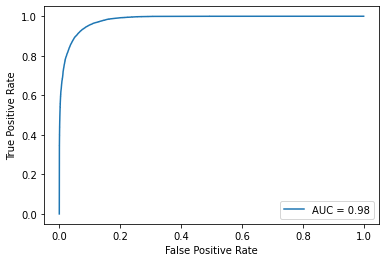

In [78]:
fpr, tpr, thresholds = roc_curve(y_test, rs_best.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.show()

AUC of 0.98!

---  

<span style="font-size:0.5em;">Tag 5</span>

### Summary <a id='summary'></a>

<span style="font-size:0.5em;"><a href='#toc_6'>Back to TOC</a></span>

Show best model again:

In [79]:
rs_best.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='entropy', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=4, max_features='sqrt', max_samples=1,
                               min_child_weight=1, min_samples_split=0.38,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=16, num_parallel_tree=1,
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,


<span style="color:blue">
    
Our metric of choice is Accuracy, and the best model found by the random search over **5** iterations applying an `XGBClassifier` had a:  

- training accuracy of **0.931**
- test accuracy was **0.932** as well
    
Other classification metrics for context are:
- Precision/Positive Predictive Value: **0.887**
- Recall/True Positive Rate: **0.896**
- ROC AUC: **0.98**

All these metrics I would consider to be very good performance, contigent on specific use case of ultimate customer(s). For example a requirement might that the customer might want to maximize PPV as much as possible and would like to target >0.90.
    
Also, note that these results are basically in sync vs our most <u>[recent neural network](./05_improved_neural_network.ipynb#summary)</u>!    
</span>

<span style="color:blue">
Compare this to the first run, before the addition of 8 more features:
</span>

<span style="color:dodgerblue">

Was also a **XGBoost classifier**.

- training accuracy of **0.928**
- test accuracy was **0.928** as well

Other classification metrics for context are:
- Precision/Positive Predictive Value: **0.885**
- Recall/True Positive Rate: **0.885**
- ROC AUC: **0.98**
</span>

<span style="color:blue">
This run is an improvement over that as well (again we're talking about differences in the hundredths).
</span>

<span style=color:blue>    
**So is it worth it to add these features? I think on balance it is.** 
    
My reasoning is that I consider the addition of them:

- `bside`
- `pside`
- `break_x`
- `break_z`
- `angle_x`
- `angle_z`
- `pitch_speed`
        
...to be 'costless', on the assumption that whatever process captures the original features that were used in the first run also 'simultaneously' capture these additional features; so no substantial extra effort is required to gather the data.
</span>

---  
### 5. Wrap Up `XGBoost` <a id='6_wrapup'></a>

<span style="font-size:0.5em;"><a href='#toc_6'>Back to TOC</a></span>



Another thing I'm curious about is feature importance. Let's extract and review.

In [86]:
# get feature importance values
dict_fi = rs_best.named_steps['clf'].get_booster().get_fscore()

fi_keys = list(dict_fi.keys())

fi_vals = list(dict_fi.values())

dict_fi = {'f_key': fi_keys
           ,'fi_vals': fi_vals
          }

display(dict_fi)

{'f_key': ['f10',
  'f9',
  'f11',
  'f0',
  'f1',
  'f4',
  'f12',
  'f6',
  'f2',
  'f3',
  'f7'],
 'fi_vals': [477, 532, 102, 335, 261, 35, 122, 233, 278, 227, 17]}

In [88]:
# 'enumerate' column names
dict_col = {'f_key': ['f' + str(x) for x in list(range(len(df_X.columns)))]
            ,'col_nm': list(df_X.columns)
           }

display(dict_col)

{'f_key': ['f0',
  'f1',
  'f2',
  'f3',
  'f4',
  'f5',
  'f6',
  'f7',
  'f8',
  'f9',
  'f10',
  'f11',
  'f12'],
 'col_nm': ['angle_x',
  'angle_z',
  'break_x',
  'break_z',
  'bside_L',
  'bside_R',
  'pitch_speed',
  'pside_L',
  'pside_R',
  'px',
  'pz',
  'stringer_zone_bottom',
  'stringer_zone_top']}

In [89]:
# Join together
df_fi_vals = pd.merge(pd.DataFrame(dict_fi), pd.DataFrame(dict_col), how='inner')

In [90]:
df_fi_vals

,f_key,fi_vals,col_nm
0,f10,477,pz
1,f9,532,px
2,f11,102,stringer_zone_bottom
3,f0,335,angle_x
4,f1,261,angle_z
5,f4,35,bside_L
6,f12,122,stringer_zone_top
7,f6,233,pitch_speed
8,f2,278,break_x
9,f3,227,break_z


In [91]:
sort_by_fi = (df_fi_vals[['col_nm', 'fi_vals']].sort_values(by=['fi_vals']
                                              , axis=0, ascending=False)
                                                ['col_nm']).values

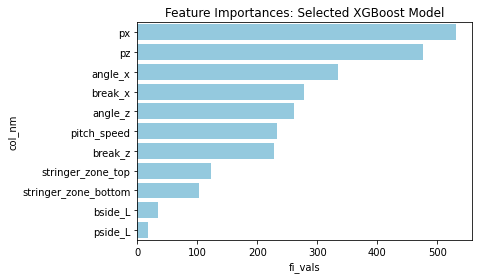

In [92]:
_ = sns.barplot(x='fi_vals', y='col_nm', data=df_fi_vals, color='skyblue'
            ,order=sort_by_fi,)
_.set(title="Feature Importances: Selected XGBoost Model")
plt.show()

Of course, as with all feature importance analytics, there's a relationship that exists with how the features interact, and their relative importance can shuffle greatly as features swap in and out, so let's keep that in the back our minds. In other words, we shouldn't be surprised if we run a similar model with added features and the features move up and down in their relative 'ranking'.

Having said that, this makes pretty intuitive sense, with regards to relative magnitude. 
- Location is extremely important to determining whether a pitch is a strike. Of course!
- Next angle, break, and speed have some importance as well. I hypothesize this helps alot in determining the X/Y travel of the pitch and how the Umpire is seeing the pitch come in.
- the Stringer values they hold some value, though i think maybe the algo figures out the thresholds independent of them.
- Lastly is batside and pitchside, which I think makes sense relatively. Of course we would hope that handedness side would have no influence on how a strike is generally perceived by the Umpire, but I'm guessing there's a small impact with regards to how individual attack the individual batters. So if a pitcher has better control to one side rather than another contigent on batter side, we should a tiny ripple of that effect, which is what I think this might be saying.



Let's designate our chosen model.

In [94]:
# This was the best model from our first RandomSearch
selected_model = rs_best

#### Make Predictions on Holdout

##### Predicted Classes

In [95]:
pred_classes = selected_model.predict(holdout_scaled)
display(pred_classes.shape)

(18633,)

Quick look at results:

In [96]:
pred_classes[:100]

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

Look at relative ratio of strikes:

In [97]:
df_pred = pd.DataFrame(pred_classes)
df_pred.value_counts(normalize=True)

0    0.691944
1    0.308056
dtype: float64

For comparison, relative ratio in training data:

In [98]:
df_y.value_counts(normalize=True)

0    0.686864
1    0.313136
Name: strike_bool, dtype: float64

Pretty close! It could be a _dangerous_ assumption, but based on what we DO know of how the datasets were constructed, the fact that the ratios are so close makes me feel that our results are pretty good.

##### Predicted Probabilities

In [99]:
pred_proba = selected_model.predict_proba(holdout_scaled)

Quick look at results:

In [100]:
np.round(pred_proba[:20], 3)

array([[0.999, 0.001],
       [1.   , 0.   ],
       [0.009, 0.991],
       [0.32 , 0.68 ],
       [0.006, 0.994],
       [1.   , 0.   ],
       [0.024, 0.976],
       [1.   , 0.   ],
       [0.004, 0.996],
       [0.994, 0.006],
       [0.026, 0.974],
       [0.056, 0.944],
       [0.457, 0.543],
       [1.   , 0.   ],
       [0.985, 0.015],
       [0.684, 0.316],
       [0.483, 0.517],
       [0.994, 0.006],
       [1.   , 0.   ],
       [0.017, 0.983]], dtype=float32)

In [101]:
pred_proba_strike_only = pred_proba[:, -1]

In [102]:
str_ts = datetime.now(timezone.utc).astimezone(pytz.timezone('US/Pacific')).strftime("%Y%m%d_%H%M")
file_class_nm = 'xgb_pred_vals_' + str_ts
file_proba_nm = 'xgb_pred_proba_' + str_ts
file_proba_stk_nm = 'xgb_pred_proba_strike_only_' + str_ts

file_class_path = './predictions/holdout/' + file_class_nm + '.csv'
file_proba_path = './predictions/holdout/' + file_proba_nm + '.csv'
file_proba_stk_path = './predictions/holdout/' + file_proba_stk_nm + '.csv'

display(file_class_path)
display(file_proba_path)
display(file_proba_stk_path)

'./predictions/holdout/xgb_pred_vals_20220512_0808.csv'

'./predictions/holdout/xgb_pred_proba_20220512_0808.csv'

'./predictions/holdout/xgb_pred_proba_strike_only_20220512_0808.csv'

In [103]:
# save out predicted probabilities
np.savetxt(file_class_path, pred_classes, delimiter=",")
np.savetxt(file_proba_path, pred_proba, delimiter=",")
np.savetxt(file_proba_stk_path, pred_proba_strike_only, delimiter=",")

---  

<span style="font-size:0.5em;">End of Current Work</span>

<a id='6_the_end'></a>

<span style="font-size:0.5em;"><a href='#toc_6'>Back to TOC</a></span>

-----